In [542]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pywt
import torch
import torch.nn as nn
import torch.optim as optim
from astropy.constants import c
from astropy import units as u

<h5> Correct for noise using wavelet denoising </h5>

In [543]:
"""
    Removes noise from the spectrum using wavelet decomposition 
    Name:       denoise()
    Parameters: 
                flux: flux data from the spectrum
                wavelet = 'db4': wavelet family (Daubechies w/ 4 vanishing moments)
                level = 1: first-level approx and detail coefficients
                threshold_type = 'soft': threshold type

    Returns:
                denoised_flux: flux without noise
"""
def denoise(flux, wavelet='db4', level=1, threshold_type='soft'):
    # Perform wavelet decomposition and get coefficients
    coeffs = pywt.wavedec(flux, wavelet, level=level)

    # Calculate the threshold
    threshold = np.std(coeffs[-1]) * np.sqrt(2 * np.log(len(flux)))

    # Apply threshold to detail coefficients
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold, mode=threshold_type)

    # Reconstruct the denoised flux
    denoised_flux = pywt.waverec(coeffs, wavelet)

    return denoised_flux



In [544]:
# Load spectrum
data = fits.getdata('hlsp_space_hst_stis_toi-1201_g140m_v1_component-spec.fits')
w, f , e, dq = data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
mask = (w > 1210) & (w < 1221)

# Denoise the spectrum
flux_denoised = denoise(f[mask]) # already masked!

# Make sure array sizes are consitent
try:
    assert len(w[mask]) == len(flux_denoised)
except AssertionError as e:
    flux_denoised = np.delete(flux_denoised, -1)

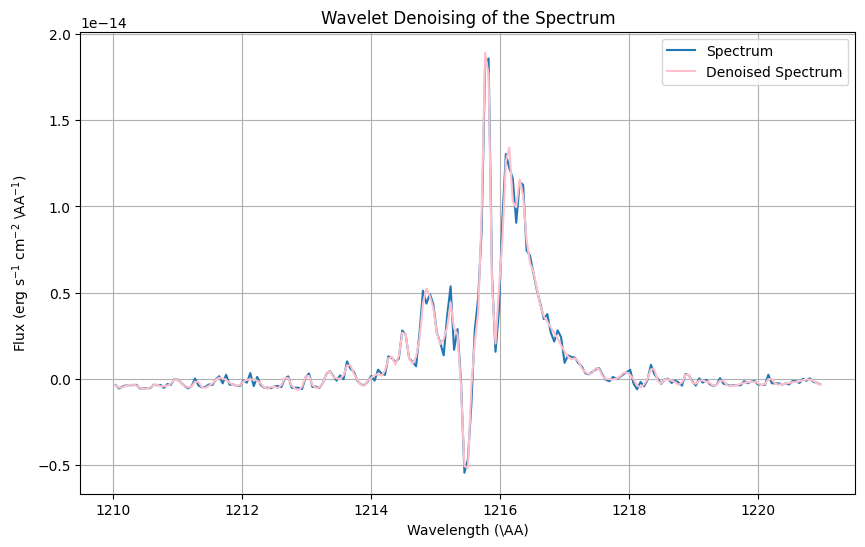

In [545]:
# Plot the updated spectrum

plt.figure(figsize=(10, 6))
plt.plot(w[mask], f[mask], label='Spectrum')
plt.plot(w[mask], flux_denoised, label='Denoised Spectrum', color='pink')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.legend()
plt.title('Wavelet Denoising of the Spectrum')
plt.grid(True)
plt.show()

<h5> Prepare the data </h5> 

In [546]:
# Normalize the wavelengths and denoised flux
normalized_denoised_flux = (flux_denoised - np.min(flux_denoised)) / (np.max(flux_denoised) - np.min(flux_denoised))
normalized_x = (w[mask] - np.min(w[mask])) / (np.max(w[mask]) - np.min(w[mask]))

# Split into training and validation sets (80% training)
num_samples = len(normalized_x)
train_size = int(0.8 * num_samples)

x_train, x_val = normalized_x[:train_size], normalized_x[train_size:]
flux_train, flux_val = normalized_denoised_flux[:train_size], normalized_denoised_flux[train_size:] 

# Organize features
x_train_tensor = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).view(-1, 1)
flux_train_tensor = torch.tensor(flux_train, dtype=torch.float32, requires_grad=True).view(-1, 1)

# Organize labels
x_val_tensor = torch.tensor(x_val, dtype=torch.float32, requires_grad=True).view(-1, 1)
flux_val_tensor = torch.tensor(flux_val, dtype=torch.float32, requires_grad=True).view(-1, 1)

print(f"x_train_tensor: {x_train_tensor.shape}")
print(f"flux_train_tensor: {flux_train_tensor.shape}")
print(f"x_val_tensor: {x_val_tensor.shape}")
print(f"flux_val_tensor: {flux_val_tensor.shape}")

# Create data loaders
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, flux_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(x_val_tensor, flux_val_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)


x_train_tensor: torch.Size([164, 1])
flux_train_tensor: torch.Size([164, 1])
x_val_tensor: torch.Size([41, 1])
flux_val_tensor: torch.Size([41, 1])


<h4> PINN without α(x) Ground Truth</h4>

In [547]:
# Constants
lya_lambda = 1215.67
c = 2997924580000000000 

# Define the PINN model (have to figure out how to take absorbtion into account)
class PINNModel(nn.Module):
    def __init__(self):
        super(PINNModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # 1 input dimension (normalized wavelength), 64 hidden units
        self.fc2 = nn.Linear(64, 64)  # 64 hidden units
        self.fc3 = nn.Linear(64, 1)  # 1 output dimension (predicted flux)

        self.alpha_x = nn.Parameter(torch.tensor(1.0, requires_grad=True)) # keep adjusting me until a good reconstruction is made

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        flux_pred = self.fc3(x)
        return flux_pred

In [548]:
"""
    use radiative transfer equation (check logic)
        ∂I/∂x = -α(x) * I(x)
        x: flux
        α(x): absorption coefficient of the medium
        I(x): F(x) / (c * λ) -> F(x) = I(x) * cλ 
            F(x): flux
    ** model would learn to predict the absorption coefficent ** <- maybe 
"""
def pinn_loss(flux_pred, x_train_tensor, flux_true, pin_model, flux_pred_derivative, training = True):
    # Data-driven loss (Mean Squared Error)
    data_loss = nn.MSELoss()(flux_pred, flux_true)

    # Physics constraint loss (Radiative Transfer Equation or other PDE)
    alpha_x = pin_model.alpha_x
    intensity_pred = flux_pred / (c * lya_lambda * alpha_x)

    # Check if in training loop
    if training:
        # Calculate the partial derivative of the predicted flux with respect to the input wavelength (x)
        flux_pred_derivative = torch.autograd.grad(flux_pred, x_train_tensor, grad_outputs=torch.ones_like(flux_pred), create_graph=True)[0]

    # Make sure all tensors have the same shapes
    flux_pred_derivative = flux_pred_derivative[:flux_pred.shape[0]]  # Trim to match the size of flux_pred
    alpha_x = alpha_x.expand_as(flux_pred)  # Expand alpha_x to match the shape of flux_pred
    intensity_pred = intensity_pred[:flux_pred.shape[0]]  # Trim to match the size of flux_pred

    # Calculate the residual (difference between left-hand side and right-hand side of the Radiative Transfer Equation)
    residual = flux_pred_derivative + alpha_x * flux_pred - intensity_pred
    
    # Physics constraint loss (Mean Squared Error of the residual)
    physics_loss = torch.mean(torch.square(residual))

    # Combine data-driven loss and physics constraint loss
    total_loss = data_loss + physics_loss

    return total_loss, flux_pred_derivative



In [549]:
# Intialize the model and set up the optimizier
pin_model = PINNModel()
optimizer = torch.optim.Adam(pin_model.parameters(), lr=0.001)

# Traing Loop
num_epochs = 1000

for epoch in range(num_epochs):
    pin_model.train()
    optimizer.zero_grad()

    # Forward pass to predict flux
    flux_pred = pin_model(x_train_tensor)

    # Calculate the PINN loss based on the physics constraint and true flux values
    loss, flux_pred_derivative = pinn_loss(flux_pred, x_train_tensor, flux_train_tensor, pin_model, 0)

    # backprop and optimization
    loss.backward()
    optimizer.step()

    # Validation set
    with torch.no_grad():
        pin_model.eval()  # Set the model to evaluation mode
        val_flux_pred = pin_model(x_val_tensor)
        
        # Calculate the PINN loss based on the physics constraint and true flux values
        val_loss, _ = pinn_loss(val_flux_pred, x_val_tensor, flux_val_tensor, pin_model, flux_pred_derivative, training=False) # maybe don't calculate the derivative?
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")




Epoch 1/1000, Loss: 0.07020935416221619, Validation Loss: 0.037196073681116104
Epoch 2/1000, Loss: 0.06279424577951431, Validation Loss: 0.03401670232415199
Epoch 3/1000, Loss: 0.057465553283691406, Validation Loss: 0.026307575404644012
Epoch 4/1000, Loss: 0.05216014385223389, Validation Loss: 0.019291497766971588
Epoch 5/1000, Loss: 0.04708939790725708, Validation Loss: 0.014843860641121864
Epoch 6/1000, Loss: 0.04312683641910553, Validation Loss: 0.012749647721648216
Epoch 7/1000, Loss: 0.040131643414497375, Validation Loss: 0.011901000514626503
Epoch 8/1000, Loss: 0.03754854574799538, Validation Loss: 0.011311317794024944
Epoch 9/1000, Loss: 0.035374965518713, Validation Loss: 0.010492231696844101
Epoch 10/1000, Loss: 0.03362734243273735, Validation Loss: 0.009608560241758823
Epoch 11/1000, Loss: 0.03235059976577759, Validation Loss: 0.009161917492747307
Epoch 12/1000, Loss: 0.03198136389255524, Validation Loss: 0.009322591125965118
Epoch 13/1000, Loss: 0.03187036141753197, Validati

Epoch 21/1000, Loss: 0.029801372438669205, Validation Loss: 0.0220030490309
Epoch 22/1000, Loss: 0.029308609664440155, Validation Loss: 0.021799569949507713
Epoch 23/1000, Loss: 0.028938371688127518, Validation Loss: 0.021956156939268112
Epoch 24/1000, Loss: 0.028657056391239166, Validation Loss: 0.022480260580778122
Epoch 25/1000, Loss: 0.028402425348758698, Validation Loss: 0.0237426720559597
Epoch 26/1000, Loss: 0.02821672521531582, Validation Loss: 0.025377731770277023
Epoch 27/1000, Loss: 0.028155576437711716, Validation Loss: 0.02676028572022915
Epoch 28/1000, Loss: 0.02821485884487629, Validation Loss: 0.027823572978377342
Epoch 29/1000, Loss: 0.0282461978495121, Validation Loss: 0.028102101758122444
Epoch 30/1000, Loss: 0.028297876939177513, Validation Loss: 0.02741187810897827
Epoch 31/1000, Loss: 0.028316190466284752, Validation Loss: 0.02662716805934906
Epoch 32/1000, Loss: 0.028331762179732323, Validation Loss: 0.025923509150743484
Epoch 33/1000, Loss: 0.028365276753902435,